In [1]:
import os
from going_modular.going_modular import data_setup, engine
import torchvision
import torch
from torch import nn
from torchinfo import summary
from tqdm.auto import tqdm
from helper_functions import plot_loss_curves, pred_and_plot_image
import matplotlib.pyplot as plt
from glob import glob
from random import sample

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dev = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# get dir data
train_dir = "/app/pytorch_zero/data/pizza_steak_sushi/train/"
test_dir = "/app/pytorch_zero/data/pizza_steak_sushi/test/"

In [4]:
# Transform weights pretrained model
weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
weights

EfficientNet_V2_S_Weights.IMAGENET1K_V1

In [5]:
auto_transform = weights.transforms()
auto_transform

ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [6]:
# dataloader for train and test
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir, test_dir=test_dir,
                                                                               transform=auto_transform,  batch_size=32,
                                                                               num_workers=1)

In [7]:
# model
model = torchvision.models.efficientnet_v2_s(weights=weights).to(dev)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [8]:
summary(model=model, input_size=[1,3,224,224],  col_names=["input_size", "output_size", "num_params","mult_adds", "trainable"],
       col_width=18, row_settings=["var_names"], depth=5) 

Layer (type (var_name))                                      Input Shape        Output Shape       Param #            Mult-Adds          Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]   [1, 1000]          --                 --                 True
├─Sequential (features)                                      [1, 3, 224, 224]   [1, 1280, 7, 7]    --                 --                 True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]   [1, 24, 112, 112]  --                 --                 True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]   [1, 24, 112, 112]  648                8,128,512          True
│    │    └─BatchNorm2d (1)                                  [1, 24, 112, 112]  [1, 24, 112, 112]  48                 48                 True
│    │    └─SiLU (2)                                         [1, 24, 112, 112]  [1, 24, 112, 112]  --                 --                 --
│  

In [1]:
# update classifier model
## Freezing the base model and change the output layer
for param in model.features.parameters():
    param.requires_grad = False # Change trainable

NameError: name 'model' is not defined

In [10]:
model.classifier # model original output layer

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [11]:
# update output layer model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True).to(dev)
)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [12]:
# define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [13]:
# train model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

results = engine.train(model=model, train_dataloader=train_dataloader, 
                       test_dataloader=test_dataloader, optimizer=optimizer,
                       loss_fn=loss_fn, epochs=5, device=dev)
results

 20%|██        | 1/5 [00:02<00:08,  2.06s/it]

Epoch: 1 | train_loss: 1.0592 | train_acc: 0.3906 | test_loss: 0.9204 | test_acc: 0.5502


 40%|████      | 2/5 [00:04<00:05,  1.99s/it]

Epoch: 2 | train_loss: 0.9074 | train_acc: 0.6602 | test_loss: 0.8157 | test_acc: 0.7955


 60%|██████    | 3/5 [00:05<00:03,  1.97s/it]

Epoch: 3 | train_loss: 0.8109 | train_acc: 0.7305 | test_loss: 0.7140 | test_acc: 0.8665


 80%|████████  | 4/5 [00:07<00:01,  1.95s/it]

Epoch: 4 | train_loss: 0.6726 | train_acc: 0.8984 | test_loss: 0.6076 | test_acc: 0.9176


100%|██████████| 5/5 [00:09<00:00,  1.96s/it]

Epoch: 5 | train_loss: 0.6755 | train_acc: 0.7695 | test_loss: 0.5933 | test_acc: 0.8759


{'train_loss': [1.0592371001839638,
  0.9073599874973297,
  0.810936689376831,
  0.6726367324590683,
  0.6755464300513268],
 'train_acc': [0.390625, 0.66015625, 0.73046875, 0.8984375, 0.76953125],
 'test_loss': [0.9204330841700236,
  0.8156658808390299,
  0.7139752507209778,
  0.6076256036758423,
  0.5933111707369486],
 'test_acc': [0.5501893939393939,
  0.7954545454545454,
  0.8664772727272728,
  0.9176136363636364,
  0.8759469696969697]}

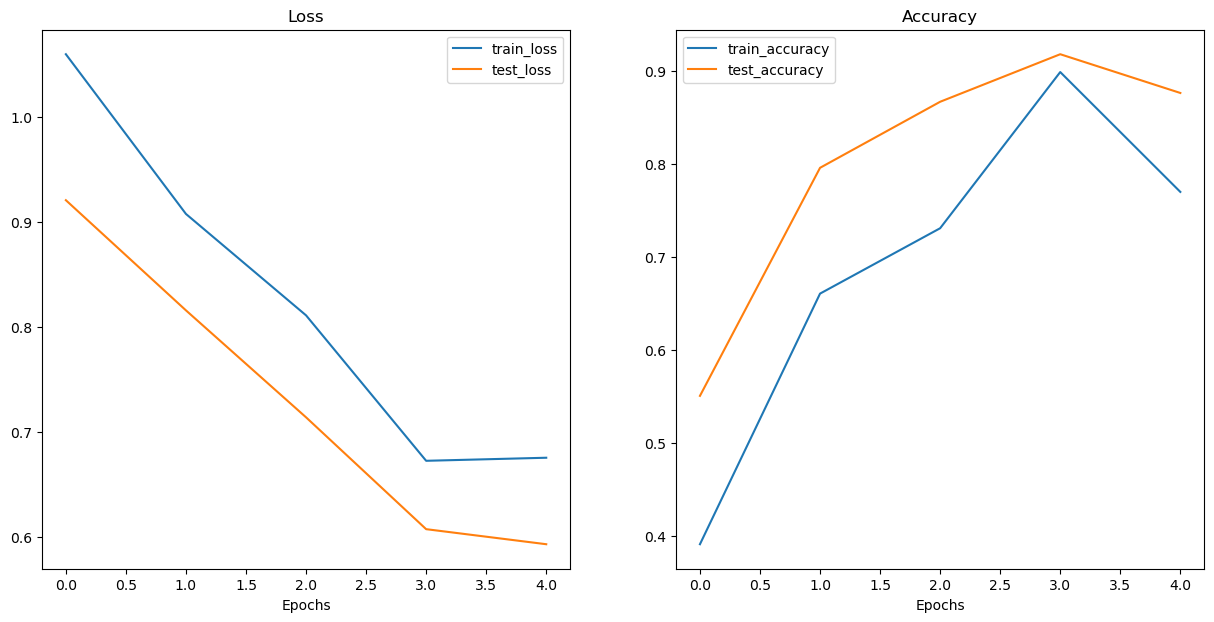

In [14]:
# plot results
plot_loss_curves(results=results)

Pred Correc: 1 is pizza
Pred Correc: 2 is steak
Pred Correc: 3 is steak


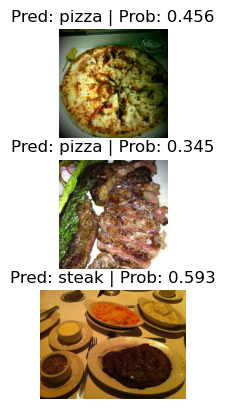

In [15]:
# make prediction on images from the test
num = 3
test_images_list = list(glob(test_dir + "/*/*.jpg"))
test_images_sample = sample(population=test_images_list, k=num)

# make plot predictions
for i in range(len(test_images_sample)):
    print(f"Pred Correc: {i+1} is {test_images_sample[i].split('/')[-2]}")
    plt.subplot(num,1,i+1)
    pred_and_plot_image(model=model, image_path=test_images_sample[i],
                        class_names=class_names)

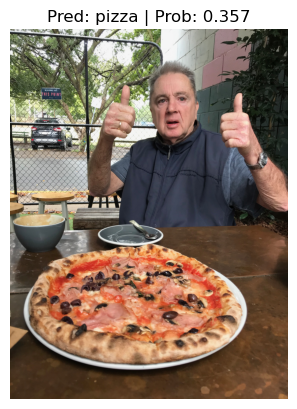

In [18]:
# Setup custom image path
custom_image_path = "/app/pytorch_zero/data/pizza_steak_sushi/04-pizza-dad.jpeg"
pred_and_plot_image(model=model, image_path=custom_image_path,
                    class_names=class_names)